# Discrete Elastic Shells: Simple Example with Four Nodes
Copyright M. Khalid Jawed (khalidjm@seas.ucla.edu). License: CC BY-NC
You should use this code at your own risk.

#Load Libraries

In [ ]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FFMpegWriter
from IPython.display import Video

#Miscellaneous Functions: signedAngle, rotateAxisAngle, parallel_transport, crossMat

In [ ]:
def signedAngle(u = None,v = None,n = None):
    # This function calculates the signed angle between two vectors, "u" and "v",
    # using an optional axis vector "n" to determine the direction of the angle.
    #
    # Parameters:
    #   u: numpy array-like, shape (3,), the first vector.
    #   v: numpy array-like, shape (3,), the second vector.
    #   n: numpy array-like, shape (3,), the axis vector that defines the plane
    #      in which the angle is measured. It determines the sign of the angle.
    #
    # Returns:
    #   angle: float, the signed angle (in radians) from vector "u" to vector "v".
    #          The angle is positive if the rotation from "u" to "v" follows
    #          the right-hand rule with respect to the axis "n", and negative otherwise.
    #
    # The function works by:
    # 1. Computing the cross product "w" of "u" and "v" to find the vector orthogonal
    #    to both "u" and "v".
    # 2. Calculating the angle between "u" and "v" using the arctan2 function, which
    #    returns the angle based on the norm of "w" (magnitude of the cross product)
    #    and the dot product of "u" and "v".
    # 3. Using the dot product of "n" and "w" to determine the sign of the angle.
    #    If this dot product is negative, the angle is adjusted to be negative.
    #
    # Example:
    #   signedAngle(np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1]))
    #   This would return a positive angle (π/2 radians), as the rotation
    #   from the x-axis to the y-axis is counterclockwise when viewed along the z-axis.
    w = np.cross(u,v)
    angle = np.arctan2( np.linalg.norm(w), np.dot(u,v) )
    if (np.dot(n,w) < 0):
        angle = - angle

    return angle

In [ ]:
def mmt(matrix):
    return matrix + matrix.T

# Hinge angle, its gradient, and Hessian

In [ ]:
#          x2
#          /\
#         /  \
#      e1/    \e3
#       /  t0  \
#      /        \
#     /    e0    \
#   x0------------x1
#     \          /
#      \   t1   /
#       \      /
#      e2\    /e4
#         \  /
#          \/
#          x3
#
#  Edge orientation: e0,e1,e2 point away from x0
#                       e3,e4 point away from x1

In [ ]:
def getTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0

    n0 = np.cross(m_e0, m_e1)
    n1 = np.cross(m_e2, m_e0)

    # Calculate the signed angle using the provided function
    theta = signedAngle(n0, n1, m_e0)

    return theta

In [ ]:
# In the original code, there are probaly TWO sign errors in the expressions for m_h3 and m_h4.
# [Original code: % https://github.com/shift09/plates-shells/blob/master/src/bending.cpp]
# I indicated those two corrections by writing the word "CORRECTION" next
# to them.

def gradTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0
    m_e3 = x2 - x1
    m_e4 = x3 - x1

    m_cosA1 = np.dot(m_e0, m_e1) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_cosA2 = np.dot(m_e0, m_e2) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_cosA3 = -np.dot(m_e0, m_e3) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_cosA4 = -np.dot(m_e0, m_e4) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_sinA1 = np.linalg.norm(np.cross(m_e0, m_e1)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_sinA2 = np.linalg.norm(np.cross(m_e0, m_e2)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_sinA3 = -np.linalg.norm(np.cross(m_e0, m_e3)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_sinA4 = -np.linalg.norm(np.cross(m_e0, m_e4)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_nn1 = np.cross(m_e0, m_e3)
    m_nn1 = m_nn1 / np.linalg.norm(m_nn1)
    m_nn2 = -np.cross(m_e0, m_e4)
    m_nn2 = m_nn2 / np.linalg.norm(m_nn2)

    m_h1 = np.linalg.norm(m_e0) * m_sinA1
    m_h2 = np.linalg.norm(m_e0) * m_sinA2
    m_h3 = -np.linalg.norm(m_e0) * m_sinA3  # CORRECTION
    m_h4 = -np.linalg.norm(m_e0) * m_sinA4  # CORRECTION
    m_h01 = np.linalg.norm(m_e1) * m_sinA1
    m_h02 = np.linalg.norm(m_e2) * m_sinA2

    # Initialize the gradient
    gradTheta = np.zeros(12)

    gradTheta[0:3] = m_cosA3 * m_nn1 / m_h3 + m_cosA4 * m_nn2 / m_h4
    gradTheta[3:6] = m_cosA1 * m_nn1 / m_h1 + m_cosA2 * m_nn2 / m_h2
    gradTheta[6:9] = -m_nn1 / m_h01
    gradTheta[9:12] = -m_nn2 / m_h02

    return gradTheta

In [ ]:
def hessTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0
    m_e3 = x2 - x1
    m_e4 = x3 - x1

    m_cosA1 = np.dot(m_e0, m_e1) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_cosA2 = np.dot(m_e0, m_e2) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_cosA3 = -np.dot(m_e0, m_e3) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_cosA4 = -np.dot(m_e0, m_e4) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_sinA1 = np.linalg.norm(np.cross(m_e0, m_e1)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_sinA2 = np.linalg.norm(np.cross(m_e0, m_e2)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_sinA3 = -np.linalg.norm(np.cross(m_e0, m_e3)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_sinA4 = -np.linalg.norm(np.cross(m_e0, m_e4)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_nn1 = np.cross(m_e0, m_e3)
    m_nn1 /= np.linalg.norm(m_nn1)
    m_nn2 = -np.cross(m_e0, m_e4)
    m_nn2 /= np.linalg.norm(m_nn2)

    m_h1 = np.linalg.norm(m_e0) * m_sinA1
    m_h2 = np.linalg.norm(m_e0) * m_sinA2
    m_h3 = -np.linalg.norm(m_e0) * m_sinA3
    m_h4 = -np.linalg.norm(m_e0) * m_sinA4
    m_h01 = np.linalg.norm(m_e1) * m_sinA1
    m_h02 = np.linalg.norm(m_e2) * m_sinA2

    # Gradient of Theta (as an intermediate step)
    grad_theta = np.zeros((12, 1))
    grad_theta[0:3] = (m_cosA3 * m_nn1 / m_h3 + m_cosA4 * m_nn2 / m_h4).reshape(-1, 1)
    grad_theta[3:6] = (m_cosA1 * m_nn1 / m_h1 + m_cosA2 * m_nn2 / m_h2).reshape(-1, 1)
    grad_theta[6:9] = (-m_nn1 / m_h01).reshape(-1, 1)
    grad_theta[9:12] = (-m_nn2 / m_h02).reshape(-1, 1)

    # Intermediate matrices for Hessian
    m_m1 = np.cross(m_nn1, m_e1) / np.linalg.norm(m_e1)
    m_m2 = -np.cross(m_nn2, m_e2) / np.linalg.norm(m_e2)
    m_m3 = -np.cross(m_nn1, m_e3) / np.linalg.norm(m_e3)
    m_m4 = np.cross(m_nn2, m_e4) / np.linalg.norm(m_e4)
    m_m01 = -np.cross(m_nn1, m_e0) / np.linalg.norm(m_e0)
    m_m02 = np.cross(m_nn2, m_e0) / np.linalg.norm(m_e0)

    # Hessian matrix components
    M331 = m_cosA3 / (m_h3 ** 2) * np.outer(m_m3, m_nn1)
    M311 = m_cosA3 / (m_h3 * m_h1) * np.outer(m_m1, m_nn1)
    M131 = m_cosA1 / (m_h1 * m_h3) * np.outer(m_m3, m_nn1)
    M3011 = m_cosA3 / (m_h3 * m_h01) * np.outer(m_m01, m_nn1)
    M111 = m_cosA1 / (m_h1 ** 2) * np.outer(m_m1, m_nn1)
    M1011 = m_cosA1 / (m_h1 * m_h01) * np.outer(m_m01, m_nn1)

    M442 = m_cosA4 / (m_h4 ** 2) * np.outer(m_m4, m_nn2)
    M422 = m_cosA4 / (m_h4 * m_h2) * np.outer(m_m2, m_nn2)
    M242 = m_cosA2 / (m_h2 * m_h4) * np.outer(m_m4, m_nn2)
    M4022 = m_cosA4 / (m_h4 * m_h02) * np.outer(m_m02, m_nn2)
    M222 = m_cosA2 / (m_h2 ** 2) * np.outer(m_m2, m_nn2)
    M2022 = m_cosA2 / (m_h2 * m_h02) * np.outer(m_m02, m_nn2)

    B1 = 1 / np.linalg.norm(m_e0) ** 2 * np.outer(m_nn1, m_m01)
    B2 = 1 / np.linalg.norm(m_e0) ** 2 * np.outer(m_nn2, m_m02)

    N13 = 1 / (m_h01 * m_h3) * np.outer(m_nn1, m_m3)
    N24 = 1 / (m_h02 * m_h4) * np.outer(m_nn2, m_m4)
    N11 = 1 / (m_h01 * m_h1) * np.outer(m_nn1, m_m1)
    N22 = 1 / (m_h02 * m_h2) * np.outer(m_nn2, m_m2)
    N101 = 1 / (m_h01 ** 2) * np.outer(m_nn1, m_m01)
    N202 = 1 / (m_h02 ** 2) * np.outer(m_nn2, m_m02)

    # Initialize Hessian of Theta
    hess_theta = np.zeros((12, 12))

    hess_theta[0:3, 0:3] = mmt(M331) - B1 + mmt(M442) - B2
    hess_theta[0:3, 3:6] = M311 + M131.T + B1 + M422 + M242.T + B2
    hess_theta[0:3, 6:9] = M3011 - N13
    hess_theta[0:3, 9:12] = M4022 - N24
    hess_theta[3:6, 3:6] = mmt(M111) - B1 + mmt(M222) - B2
    hess_theta[3:6, 6:9] = M1011 - N11
    hess_theta[3:6, 9:12] = M2022 - N22
    hess_theta[6:9, 6:9] = -mmt(N101)
    hess_theta[9:12, 9:12] = -mmt(N202)

    # Make the Hessian symmetric
    hess_theta[3:6, 0:3] = hess_theta[0:3, 3:6].T
    hess_theta[6:9, 0:3] = hess_theta[0:3, 6:9].T
    hess_theta[9:12, 0:3] = hess_theta[0:3, 9:12].T
    hess_theta[6:9, 3:6] = hess_theta[3:6, 6:9].T
    hess_theta[9:12, 3:6] = hess_theta[3:6, 9:12].T

    return hess_theta


# Stretching energy for a shell, it's gradient, and Hessian

In [ ]:
def gradEs_hessEs(node0 = None,node1 = None,l_k = None,EA = None):

# Inputs:
# node0: 1x3 vector - position of the first node
# node1: 1x3 vector - position of the last node

# l_k: reference length (undeformed) of the edge
# EA: scalar - stretching stiffness - Young's modulus times area

# Outputs:
# dF: 6x1  vector - gradient of the stretching energy between node0 and node 1.
# dJ: 6x6 vector - hessian of the stretching energy between node0 and node 1.

    ## Gradient of Es
    edge = node1 - node0

    edgeLen = np.linalg.norm(edge)
    tangent = edge / edgeLen
    epsX = edgeLen / l_k - 1
    dF_unit = EA * tangent * epsX
    dF = np.zeros((6))
    dF[0:3] = - dF_unit
    dF[3:6] = dF_unit

    ## Hessian of Es
    Id3 = np.eye(3)
    M = EA * ((1 / l_k - 1 / edgeLen) * Id3 + 1 / edgeLen * ( np.outer( edge, edge ) ) / edgeLen ** 2)

    dJ = np.zeros((6,6))
    dJ[0:3,0:3] = M
    dJ[3:6,3:6] = M
    dJ[0:3,3:6] = - M
    dJ[3:6,0:3] = - M
    return dF,dJ

# Bending energy for a shell, it's gradient, and Hessian

In [ ]:
def getEb_Shell(x0, x1=None, x2=None, x3=None, theta_bar=0, kb=1.0):
    """
    Compute the bending energy for a shell.

    Returns:
    E (scalar): Bending energy.
    """
    # Allow another type of input where x0 contains all the information
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[:3]

    # Compute theta, gradient, and Hessian
    theta = getTheta(x0, x1, x2, x3)  # Replace with your getTheta function in Python
    grad = gradTheta(x0, x1, x2, x3)  # Replace with your gradTheta function in Python

    # E = 0.5 * kb * (theta-thetaBar)^2
    E = 0.5 * kb * (theta - theta_bar) ** 2

    return E

In [ ]:
def gradEb_hessEb_Shell(x0, x1=None, x2=None, x3=None, theta_bar=0, kb=1.0):
    """
    Compute the gradient and Hessian of the bending energy for a shell.

    Parameters:
    x0 (array): Can either be a 3-element array (single point) or a 12-element array.
    x1, x2, x3 (arrays): Optional, 3-element arrays specifying points.
    theta_bar (float): Reference angle.
    kb (float): Bending stiffness.

    Returns:
    dF (array): Gradient of the bending energy.
    dJ (array): Hessian of the bending energy.
    """
    # Allow another type of input where x0 contains all the information
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[:3]

    # Compute theta, gradient, and Hessian
    theta = getTheta(x0, x1, x2, x3)  # Replace with your getTheta function in Python
    grad = gradTheta(x0, x1, x2, x3)  # Replace with your gradTheta function in Python

    # E = 0.5 * kb * (theta-thetaBar)^2
    # F = dE/dx = 2 * (theta-thetaBar) * gradTheta
    dF = 0.5 * kb * (2 * (theta - theta_bar) * grad)

    # E = 0.5 * kb * (theta-thetaBar)^2
    # F = 0.5 * kb * (2 (theta-thetaBar) d theta/dx)
    # J = dF/dx = 0.5 * kb * [ 2 (d theta / dx) transpose(d theta/dx) +
    #       2 (theta-thetaBar) (d^2 theta/ dx^2 ) ]
    hess = hessTheta(x0, x1, x2, x3)  # Replace with your hessTheta function in Python
    dJ = 0.5 * kb * (2 * np.outer(grad, grad) + 2 * (theta - theta_bar) * hess)

    return dF, dJ

#Plot the shell

In [ ]:
# Function to set equal aspect ratio for 3D plots
def set_axes_equal(ax):
    """
    Set equal aspect ratio for a 3D plot in Matplotlib.
    This function adjusts the limits of the plot to make sure
    that the scale is equal along all three axes.
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max(x_range, y_range, z_range)

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])

In [ ]:
def plotShell(x0, ctime):
    fig = plt.figure(1)
    clear_output()
    plt.clf()  # Clear the figure
    ax = fig.add_subplot(111, projection='3d')

    # Reshape the array into node coordinates (80 nodes total, 3 coords each)
    nodes = x0.reshape(-1, 3)

    # Separate nodes into 5 layers
    layer0 = nodes[0::5]  # Indices: 0, 5, 10, ... (bottom layer, y=0)
    layer1 = nodes[1::5]  # Indices: 1, 6, 11, ... (y=3/5)
    layer2 = nodes[2::5]  # Indices: 2, 7, 12, ... (y=6/5)
    layer3 = nodes[3::5]  # Indices: 3, 8, 13, ... (y=9/5)
    layer4 = nodes[4::5]  # Indices: 4, 9, 14, ... (top layer, y=12/5)

    layers = [layer0, layer1, layer2, layer3, layer4]

    # Plot vertical edges connecting consecutive layers
    for i in range(len(layer0)):
        for j in range(4):  # Connect layer j to layer j+1
            ax.plot3D([layers[j][i, 0], layers[j+1][i, 0]],
                      [layers[j][i, 1], layers[j+1][i, 1]],
                      [layers[j][i, 2], layers[j+1][i, 2]], 'k-')

    # Plot horizontal edges along each layer
    for layer in layers:
        for i in range(len(layer) - 1):
            ax.plot3D([layer[i, 0], layer[i+1, 0]],
                      [layer[i, 1], layer[i+1, 1]],
                      [layer[i, 2], layer[i+1, 2]], 'k-')

    # Plot diagonal edges with alternating pattern
    for i in range(len(layer0) - 1):
        for j in range(4):  # For each pair of consecutive layers
            if i % 2 == 0:
                # Even index: diagonal from top layer to bottom layer
                ax.plot3D([layers[j+1][i, 0], layers[j][i+1, 0]],
                          [layers[j+1][i, 1], layers[j][i+1, 1]],
                          [layers[j+1][i, 2], layers[j][i+1, 2]], 'k-')
            else:
                # Odd index: diagonal from bottom layer to top layer
                ax.plot3D([layers[j][i, 0], layers[j+1][i+1, 0]],
                          [layers[j][i, 1], layers[j+1][i+1, 1]],
                          [layers[j][i, 2], layers[j+1][i+1, 2]], 'k-')

    # Plot nodes - fixed nodes at first position of bottom and top layers
    fixed_bottom = layer0[0]
    fixed_top = layer4[0]
    ax.plot3D([fixed_bottom[0]], [fixed_bottom[1]], [fixed_bottom[2]],
              'ko', markersize=2, markerfacecolor='white')
    ax.plot3D([fixed_top[0]], [fixed_top[1]], [fixed_top[2]],
              'ko', markersize=2, markerfacecolor='white')

    # Plot free nodes (open circles) - all other nodes
    for layer_idx, layer in enumerate(layers):
        start_idx = 1 if layer_idx in [0, 4] else 0  # Skip first node for bottom and top layers
        for i in range(start_idx, len(layer)):
            ax.plot3D([layer[i, 0]], [layer[i, 1]], [layer[i, 2]],
                      'ko', markersize=2, markerfacecolor='white')

    # Set the title with current time
    ax.set_title(f't={ctime:.2f}')

    # Set axes labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Set equal scaling and a 3D view
    set_axes_equal(ax)
    plt.draw()  # Force a redraw of the figure
    plt.show()


In [ ]:
def plotShell_movie(x0, ctime, ax=None, show=True):
    """
    Function to plot the shell structure with nodes and edges.

    Parameters:
    - x0: Position vector (DOF vector).
    - ctime: Current time for title.
    - ax: Axis to draw on. If None, a new figure is created (interactive mode).
    - show: If True and ax is None, show the figure (for interactive use).
    """

    if ax is None:
        # Original interactive behaviour
        fig = plt.figure(1)
        clear_output(wait=True)
        plt.clf()
        ax = fig.add_subplot(111, projection='3d')
    else:
        # Movie mode: reuse same axis
        ax.cla()

    # Reshape the array into node coordinates
    nodes = x0.reshape(-1, 3)

    # Separate nodes into 5 layers
    layer0 = nodes[0::5]  # Indices: 0, 5, 10, ... (bottom layer, y=0)
    layer1 = nodes[1::5]  # Indices: 1, 6, 11, ... (y=3/5)
    layer2 = nodes[2::5]  # Indices: 2, 7, 12, ... (y=6/5)
    layer3 = nodes[3::5]  # Indices: 3, 8, 13, ... (y=9/5)
    layer4 = nodes[4::5]  # Indices: 4, 9, 14, ... (top layer, y=12/5)

    layers = [layer0, layer1, layer2, layer3, layer4]

    # Plot vertical edges connecting consecutive layers
    for i in range(len(layer0)):
        for j in range(4):  # Connect layer j to layer j+1
            ax.plot3D([layers[j][i, 0], layers[j+1][i, 0]],
                      [layers[j][i, 1], layers[j+1][i, 1]],
                      [layers[j][i, 2], layers[j+1][i, 2]], 'k-', linewidth=0.5)

    # Plot horizontal edges along each layer
    for layer in layers:
        for i in range(len(layer) - 1):
            ax.plot3D([layer[i, 0], layer[i+1, 0]],
                      [layer[i, 1], layer[i+1, 1]],
                      [layer[i, 2], layer[i+1, 2]], 'k-', linewidth=0.5)

    # Plot diagonal edges with alternating pattern
    for i in range(len(layer0) - 1):
        for j in range(4):  # For each pair of consecutive layers
            if i % 2 == 0:
                # Even index: diagonal from top layer to bottom layer
                ax.plot3D([layers[j+1][i, 0], layers[j][i+1, 0]],
                          [layers[j+1][i, 1], layers[j][i+1, 1]],
                          [layers[j+1][i, 2], layers[j][i+1, 2]], 'k-', linewidth=0.5)
            else:
                # Odd index: diagonal from bottom layer to top layer
                ax.plot3D([layers[j][i, 0], layers[j+1][i+1, 0]],
                          [layers[j][i, 1], layers[j+1][i+1, 1]],
                          [layers[j][i, 2], layers[j+1][i+1, 2]], 'k-', linewidth=0.5)

    # Plot all nodes as black circles with white fill
    for layer in layers:
        for i in range(len(layer)):
            ax.plot3D([layer[i, 0]], [layer[i, 1]], [layer[i, 2]],
                      'ko', markersize=2, markerfacecolor='white')

    # Set the title with current time
    ax.set_title(f't={ctime:.2f}')

    # Set axes labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Set equal scaling and a 3D view
    set_axes_equal(ax)

    if ax is None and show:
        plt.draw()
        plt.show()

# Hydrodynamic Forces

In [ ]:
def getF_highRe_shell(q, q_old, dt, rho, Cd, A, u_f=None):
    """
    High Reynolds number hydrodynamic drag for Shell nodes
    Uses the quadratic drag law: F = -0.5 * rho * Cd * A * |v| * v

    Parameters
    ----------
    q : array_like
        new DOF
    q_old : array_like
        old DOF
    dt : float
        time step
    rho : float
        fluid density
    Cd : array_like
        drag coefficient for each node
    A : array_like
        cross-sectional area for each node
    u_f : array_like, shape (3,), optional
        fluid velocity

    Returns
    -------
    Fh : array_like, shape (ndof,)
        hydrodynamic force residual
    Jh : array_like, shape (ndof, ndof)
        Jacobian of the hydrodynamic contribution w.r.t. q
    """
    ndof = q.shape[0]
    nv = ndof // 3   # number of nodes

    if u_f is None:
        u_f = np.zeros(3)
    else:
        u_f = np.asarray(u_f, dtype=float)

    # Extract nodal positions at old and new times
    x_new = np.zeros((nv, 3))
    x_old = np.zeros((nv, 3))
    for k in range(nv):
        idx = 3 * k
        x_new[k, :] = q[idx:idx+3]
        x_old[k, :] = q_old[idx:idx+3]

    # Nodal velocities (backward Euler)
    u = (x_new - x_old) / dt

    # Allocate residual and Jacobian
    Fh = np.zeros(ndof)
    Jh = np.zeros((ndof, ndof))

    # Precompute drag coefficient
    coeff = 0.5 * rho * Cd * A

    for k in range(nv):
        # Relative velocity
        u_rel = u[k] - u_f
        u_rel_norm = np.linalg.norm(u_rel)

        # Avoid singularity when velocity is near zero
        eps = 1e-10
        if u_rel_norm < eps:
            # No drag force or Jacobian contribution
            continue

        # Physical hydrodynamic drag force: F = -0.5 * rho * Cd * A * |v| * v
        f_drag = - coeff[k] * u_rel_norm * u_rel

        # Jacobian: d/du_rel [ |u_rel| * u_rel ]
        # d/du_rel [ |u_rel| * u_rel ] = |u_rel| * I + u_rel * (u_rel^T / |u_rel|)
        #                               = |u_rel| * I + (u_rel * u_rel^T) / |u_rel|
        J_block = - coeff[k] * (u_rel_norm * np.eye(3) + np.outer(u_rel, u_rel) / u_rel_norm)

        # Apply chain rule: d/dx = (1/dt) * d/du
        J_block = J_block / dt

        # Indices of translational DOFs of node k in q
        idx = np.array([3*k, 3*k+1, 3*k+2])

        # Assemble
        Fh[idx] += f_drag
        Jh[np.ix_(idx, idx)] += J_block

    return Fh, Jh

In [ ]:
def getF_highRe_shell_2(q, q_old, dt, rho, Cd_n, Cd_t, edges, u_f=None):
    """
    High Reynolds number hydrodynamic drag for Shell with anisotropic drag
    Uses normal drag (pressure drag) and tangential drag (skin friction)

    For each triangle:
    - Normal drag: F_n = -0.5 * rho * Cd_n * A_projected * |v_n| * v_n
    - Tangential drag: F_t = -0.5 * rho * Cd_t * A_triangle * |v_t| * v_t

    where A_projected is the triangle area projected onto the plane perpendicular to flow

    Parameters
    ----------
    q : array_like
        new DOF
    q_old : array_like
        old DOF
    dt : float
        time step
    rho : float
        fluid density
    Cd_n : float
        normal drag coefficient (pressure drag)
    Cd_t : float
        tangential drag coefficient (skin friction)
    edges : array_like, shape (n_edges, 2)
        edge connectivity for identifying triangles
    u_f : array_like, shape (3,), optional
        fluid velocity

    Returns
    -------
    Fh : array_like, shape (ndof,)
        hydrodynamic force residual
    Jh : array_like, shape (ndof, ndof)
        Jacobian of the hydrodynamic contribution w.r.t. q
    """
    ndof = q.shape[0]
    nv = ndof // 3   # number of nodes

    if u_f is None:
        u_f = np.zeros(3)
    else:
        u_f = np.asarray(u_f, dtype=float)

    # Extract nodal positions at old and new times
    x_new = np.zeros((nv, 3))
    x_old = np.zeros((nv, 3))
    for k in range(nv):
        idx = 3 * k
        x_new[k, :] = q[idx:idx+3]
        x_old[k, :] = q_old[idx:idx+3]

    # Nodal velocities (backward Euler)
    u = (x_new - x_old) / dt

    # Allocate residual and Jacobian
    Fh = np.zeros(ndof)
    Jh = np.zeros((ndof, ndof))

    # Identify triangles from edges
    # Build adjacency to find triangular faces
    triangles = find_triangles_from_edges(edges, nv)

    eps = 1e-10

    # Process each triangle
    for tri in triangles:
        n0, n1, n2 = tri

        # Triangle vertices
        p0 = x_new[n0]
        p1 = x_new[n1]
        p2 = x_new[n2]

        # Triangle edges
        e1 = p1 - p0
        e2 = p2 - p0

        # Triangle normal (not normalized) - magnitude is 2*Area
        normal_vec = np.cross(e1, e2)
        area_triangle = 0.5 * np.linalg.norm(normal_vec)

        if area_triangle < eps:
            continue

        # Unit normal
        n_hat = normal_vec / (2 * area_triangle)

        # Average velocity of triangle
        u_tri = (u[n0] + u[n1] + u[n2]) / 3.0
        u_rel = u_tri - u_f
        u_rel_norm = np.linalg.norm(u_rel)

        if u_rel_norm < eps:
            continue

        # Unit direction of relative velocity
        u_rel_hat = u_rel / u_rel_norm

        # Decompose velocity into normal and tangential components
        u_n = np.dot(u_rel, n_hat) * n_hat  # normal component
        u_t = u_rel - u_n  # tangential component

        u_n_norm = np.linalg.norm(u_n)
        u_t_norm = np.linalg.norm(u_t)

        # Projected area (planform area perpendicular to flow)
        # A_proj = A * |cos(theta)| where theta is angle between normal and flow
        cos_theta = np.abs(np.dot(n_hat, u_rel_hat))
        A_projected = area_triangle * cos_theta

        # Normal drag force (pressure drag on projected area)
        if u_n_norm > eps:
            coeff_n = 0.5 * rho * Cd_n * A_projected
            f_drag_n = -coeff_n * u_n_norm * u_n
        else:
            f_drag_n = np.zeros(3)
            coeff_n = 0.0

        # Tangential drag force (skin friction on triangle area)
        if u_t_norm > eps:
            coeff_t = 0.5 * rho * Cd_t * area_triangle
            f_drag_t = -coeff_t * u_t_norm * u_t
        else:
            f_drag_t = np.zeros(3)
            coeff_t = 0.0

        # Total drag force on triangle
        f_drag_total = f_drag_n + f_drag_t

        # Distribute force equally to three nodes (or use area coordinates)
        f_node = f_drag_total / 3.0

        # Assemble force
        for node in [n0, n1, n2]:
            idx = np.array([3*node, 3*node+1, 3*node+2])
            Fh[idx] += f_node

        # Compute Jacobian contributions
        # For simplicity, we'll use a simplified Jacobian that assumes
        # the triangle normal and area don't change significantly

        # Jacobian for normal component: d/du_n [ |u_n| * u_n ]
        if u_n_norm > eps:
            J_n = -coeff_n * (u_n_norm * np.eye(3) + np.outer(u_n, u_n) / u_n_norm)
            # Project onto normal direction
            P_n = np.outer(n_hat, n_hat)
            J_n = J_n @ P_n
        else:
            J_n = np.zeros((3, 3))

        # Jacobian for tangential component: d/du_t [ |u_t| * u_t ]
        if u_t_norm > eps:
            J_t = -coeff_t * (u_t_norm * np.eye(3) + np.outer(u_t, u_t) / u_t_norm)
            # Project onto tangential plane
            P_t = np.eye(3) - np.outer(n_hat, n_hat)
            J_t = J_t @ P_t
        else:
            J_t = np.zeros((3, 3))

        # Total Jacobian block (for velocity)
        J_block = (J_n + J_t) / dt / 3.0  # divide by 3 for averaging

        # Distribute Jacobian to nodes
        for node_i in [n0, n1, n2]:
            for node_j in [n0, n1, n2]:
                idx_i = np.array([3*node_i, 3*node_i+1, 3*node_i+2])
                idx_j = np.array([3*node_j, 3*node_j+1, 3*node_j+2])
                Jh[np.ix_(idx_i, idx_j)] += J_block

    return Fh, Jh




In [ ]:
def find_triangles_from_edges(edges, nv):
    """
    Find all triangles in the mesh from edge connectivity

    Parameters
    ----------
    edges : array_like, shape (n_edges, 2)
        edge connectivity
    nv : int
        number of vertices

    Returns
    -------
    triangles : list of tuples
        list of (n0, n1, n2) triangle vertex indices
    """
    from collections import defaultdict

    # Build adjacency list
    adj = defaultdict(set)
    for e in edges:
        n0, n1 = int(e[0]), int(e[1])
        adj[n0].add(n1)
        adj[n1].add(n0)

    # Find triangles (sets of 3 mutually connected nodes)
    triangles = []
    for n0 in range(nv):
        neighbors = list(adj[n0])
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                # Check if n1 and n2 are connected
                if n2 in adj[n1]:
                    # Found a triangle, add in sorted order to avoid duplicates
                    tri = tuple(sorted([n0, n1, n2]))
                    if tri not in triangles:
                        triangles.append(tri)

    return triangles

# Objective function

In [ ]:
def objfun(qOld, uOld, freeIndex, dt, tol, massVector, massMatrix,
           ks, refLen, edges,
           kb, thetaBar, hinges,
           Fg, visc, rho_fluid, Cd_n, Cd_t, u_f):

  qNew = qOld.copy()
  ndof = len(qOld) # Number of DOFs

  iter = 0 # number of iteration
  error = 10 * tol
  # Newton Raphson
  while error > tol:


    # Bending force and jacobian
    Fb = np.zeros( ndof )
    Jb = np.zeros( (ndof,ndof) )
    # Loop over every "bending spring" or "hinge"
    for kHinge in range(hinges.shape[0]):
      node0 = hinges[kHinge, 0]
      node1 = hinges[kHinge, 1]
      node2 = hinges[kHinge, 2]
      node3 = hinges[kHinge, 3]
      x0 = qNew[ 3*node0: 3*node0 + 3]
      x1 = qNew[ 3*node1: 3*node1 + 3]
      x2 = qNew[ 3*node2: 3*node2 + 3]
      x3 = qNew[ 3*node3: 3*node3 + 3]
      ind = [3*node0, 3*node0 + 1, 3*node0 + 2,
             3*node1, 3*node1 + 1, 3*node1 + 2,
             3*node2, 3*node2 + 1, 3*node2 + 2,
             3*node3, 3*node3 + 1, 3*node3 + 2]
      dF, dJ = gradEb_hessEb_Shell(x0, x1, x2, x3, 0, kb)
      Fb[ind] -= dF
      Jb[np.ix_(ind,ind)] -= dJ

    # Stretching force and jacobian
    Fs = np.zeros( ndof )
    Js = np.zeros( (ndof,ndof) )
    for kEdge in range(edges.shape[0]):
      node0 = edges[kEdge, 0]
      node1 = edges[kEdge, 1]
      x0 = qNew[ 3*node0: 3*node0 + 3]
      x1 = qNew[ 3*node1: 3*node1 + 3]
      ind = [3*node0, 3*node0 + 1, 3*node0 + 2,
             3*node1, 3*node1 + 1, 3*node1 + 2]
      dF, dJ = gradEs_hessEs(x0, x1, refLen[kEdge], ks[kEdge])
      Fs[ind] -= dF
      Js[np.ix_(ind,ind)] -= dJ

    # Viscous force
    Fv = 0#- visc * (qNew - qOld) / dt
    Jv = 0#- visc / dt * np.eye(ndof)


    # Hydrodynamic forces
    Fh, Jh = getF_highRe_shell_2(qNew, qOld, dt, rho_fluid, Cd_n, Cd_t, edges, u_f)

    Forces = Fb + Fs + Fg + Fv + Fh # Sum of forces (added Fh)
    JForces = Jb + Js + Jv + Jh # Sum of Jacobians (added Jh)

    # Set up my equations of motion and calculating its residual (=0)
    f = massVector / dt * ( (qNew - qOld)/dt - uOld) - Forces # Residual of EOM
    J = massMatrix / dt ** 2 - JForces

    # Extract the free part of the f and J arrays
    f_free = f[freeIndex]
    J_free = J[np.ix_(freeIndex, freeIndex)]
    # Correction
    dq_free = np.linalg.solve(J_free, f_free)

    # Update my guess for position
    qNew[freeIndex] -= dq_free

    # Calculate error
    error = np.sum( np.abs(f_free))

    iter += 1

    print('Iter = ', iter, ' error=', error)

  uNew = (qNew - qOld) / dt
  return qNew, uNew

#Main Discrete Shells

**DOFs and Nodes**

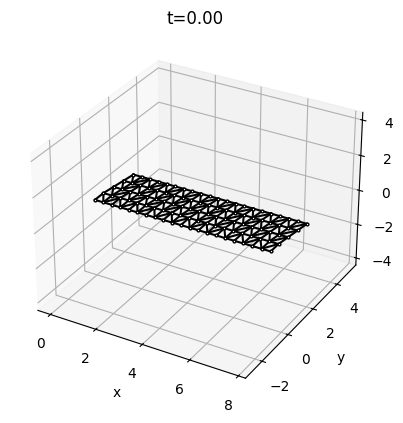

In [ ]:
nNodes = 105
qOld = np.zeros(3*nNodes)

for i in range(nNodes):
  if i % 5 == 0:
    qOld[3*i] = 0.15 * i/2  # x-coord
    qOld[3*i+1] = 0         # y-coord
    qOld[3*i+2] = 0         # z-coord
  elif i % 5 == 1:
    qOld[3*i] = 0.15 * (i-1)/2  # x-coord
    qOld[3*i+1] = 3/5       # y-coord
    qOld[3*i+2] = 0         # z-coord
  elif i % 5 == 2:
    qOld[3*i] = 0.15 * (i-1)/2  # x-coord
    qOld[3*i+1] = 3/ 5 * 2      # y-coord
    qOld[3*i+2] = 0         # z-coord
  elif i % 5 == 3:
    qOld[3*i] = 0.15 * (i-1)/2  # x-coord
    qOld[3*i+1] = 3 / 5 * 3      # y-coord
    qOld[3*i+2] = 0         # z-coord
  elif i % 5 == 4:
    qOld[3*i] = 0.15 * (i-1)/2  # x-coord
    qOld[3*i+1] = 3 / 5 * 4      # y-coord
    qOld[3*i+2] = 0         # z-coord
  else:
    qOld[3*i] = 0.15 * (i-1)/2  # x-coord
    qOld[3*i+1] = 3       # y-coord
    qOld[3*i+2] = 0         # z-coord

plotShell(qOld, 0)

ndof = 3 * nNodes


In [ ]:
midColumn = (nNodes/5)//2

**Springs: Create edges (stretching) and hinges (bending)**

In [ ]:
# Create edges array (horizontal, vertical, and diagonal connections)
edges_list = []

# Number of columns
nCols = 21  # 100 nodes / 5 layers = 20 columns

# Vertical edges (connecting consecutive layers within each column)
for col in range(nCols):
    for layer in range(4):  # Connect layer to layer+1
        node_idx = 5 * col + layer
        next_node_idx = 5 * col + layer + 1
        edges_list.append((node_idx, next_node_idx))

# Horizontal edges along each layer
for layer in range(5):
    for col in range(nCols - 1):
        node_idx = 5 * col + layer
        next_node_idx = 5 * (col + 1) + layer
        edges_list.append((node_idx, next_node_idx))

# Diagonal edges between consecutive layers
for col in range(nCols - 1):
    for layer in range(4):  # For each pair of consecutive layers
        if col % 2 == 0:
            # Even column: diagonal from upper layer to lower layer of next column
            upper_idx = 5 * col + layer + 1
            lower_idx = 5 * (col + 1) + layer
        else:
            # Odd column: diagonal from lower layer to upper layer of next column
            lower_idx = 5 * col + layer
            upper_idx = 5 * (col + 1) + layer + 1
        edges_list.append((upper_idx, lower_idx))

edges = np.array(edges_list)


# Create hinges array (connections forming bending sites)
hinges_list = []

# Hinges along diagonal edges (horizontal bending between triangular faces)
for col in range(nCols - 1):
    for layer in range(4):  # For each pair of consecutive layers
        # Node indices for current column
        lower_i = 5 * col + layer
        upper_i = 5 * col + layer + 1
        # Node indices for next column
        lower_i1 = 5 * (col + 1) + layer
        upper_i1 = 5 * (col + 1) + layer + 1

        if col % 2 == 0:
            # Even column: diagonal from upper[i] to lower[i+1]
            hinges_list.append((upper_i, lower_i1, upper_i1, lower_i))
        else:
            # Odd column: diagonal from lower[i] to upper[i+1]
            hinges_list.append((lower_i, upper_i1, lower_i1, upper_i))

# Hinges for vertical edges (connecting left and right triangular faces)
for col in range(1, nCols - 1):  # Interior columns
    for layer in range(4):  # For each vertical edge
        # Current edge nodes
        lower = 5 * col + layer
        upper = 5 * col + layer + 1

        # Previous column nodes
        lower_prev = 5 * (col - 1) + layer
        upper_prev = 5 * (col - 1) + layer + 1

        # Next column nodes
        lower_next = 5 * (col + 1) + layer
        upper_next = 5 * (col + 1) + layer + 1

        if col % 2 == 1:
            # Odd column: vertical edge connects two triangles
            # Left triangle has diagonal from upper_prev to lower
            # Right triangle has diagonal from lower to upper_next
            hinges_list.append((lower, upper, upper_prev, upper_next))
        else:
            # Even column: vertical edge connects two triangles
            # Left triangle has diagonal from lower_prev to upper
            # Right triangle has diagonal from upper to lower_next
            hinges_list.append((upper, lower, lower_prev, lower_next))

hinges = np.array(hinges_list)

print("Edges shape:", edges.shape)
print("Number of edges:", len(edges))
print("\nHinges shape:", hinges.shape)
print("Number of hinges:", len(hinges))


Edges shape: (264, 2)
Number of edges: 264

Hinges shape: (156, 4)
Number of hinges: 156


**Elastic Stiffness**

In [ ]:
Y = 5.5e10 # 2.7 GPa - Young's modulus #Nylon
h = 0.002 # Thickness in meter
l = 6   # m
w = 3  # m
A = w * h # Area in m^2
E = Y * A # Elastic modulus
I = w * h**3 / 12   # Moment of Inertia

# Stiffness variables
kb = 2.0 / np.sqrt(3.0) * Y * h**3.0 / 12 # Bending stiffness (Newton-meter)
refLen = np.zeros(edges.shape[0]) # reference length, denoted as l_k
ks = np.ones_like(refLen) # Stretching stiffness
for kEdge in range(edges.shape[0]):
  node0 = edges[kEdge, 0]
  node1 = edges[kEdge, 1]
  x0 = qOld[ 3*node0: 3*node0 + 3]
  x1 = qOld[ 3*node1: 3*node1 + 3]
  refLen[kEdge] = np.linalg.norm(x1 - x0)
  ks[kEdge] = np.sqrt(3.0) / 2.0 * Y * h * (refLen[kEdge]) ** 2

**Time parameters**

In [ ]:
totalTime = 10 # seconds
dt = 0.005 # time step sie

tol = kb / (0.01)*1E-3  # Approximate tolerance

**Mass Vector and Matrix**

In [ ]:
rho = 1.15e3 # Density
totalM = w * h * l * rho # total mass in kg
dm = totalM / nNodes # mass per nodes -- approximation
massVector = np.zeros(ndof)
for c in range(nNodes): # Loop over every node
  ind = [3*c, 3*c+1, 3*c+2] # location of the c-th node in the DOF vector
  massVector[ind] = dm

massMatrix = np.diag(massVector)

**External force**

**Natural curvature**

In [ ]:
g = np.array([0, 0, -9.8])

midNode = 10

Load = 2000

Fg = np.zeros(ndof)
for c in range(nNodes):
  ind = [3*c, 3*c+1, 3*c+2]
  Fg[ind] = massVector[ind] * g

  # first Node
  if c == 0:
    Fg[3*c+2] = Fg[3*c+2]-0.2*Load

  if c == 4:
    Fg[3*c+2] = Fg[3*c+2]-0.2*Load

  # Mid Column
  if c == midColumn*5:
    Fg[3*c+2] = Fg[3*c+2]-0.1*Load

  if c == midColumn*5 + 4:
    Fg[3*c+2] = Fg[3*c+2]-0.1*Load

  # last Node
  if c == nNodes-5:
    Fg[3*c+2] = Fg[3*c+2]-0.2*Load

  if c == nNodes-1:
    Fg[3*c+2] = Fg[3*c+2]-0.2*Load

print(Fg)


[   0.       0.    -403.864    0.       0.      -3.864    0.       0.
   -3.864    0.       0.      -3.864    0.       0.    -403.864    0.
    0.      -3.864    0.       0.      -3.864    0.       0.      -3.864
    0.       0.      -3.864    0.       0.      -3.864    0.       0.
   -3.864    0.       0.      -3.864    0.       0.      -3.864    0.
    0.      -3.864    0.       0.      -3.864    0.       0.      -3.864
    0.       0.      -3.864    0.       0.      -3.864    0.       0.
   -3.864    0.       0.      -3.864    0.       0.      -3.864    0.
    0.      -3.864    0.       0.      -3.864    0.       0.      -3.864
    0.       0.      -3.864    0.       0.      -3.864    0.       0.
   -3.864    0.       0.      -3.864    0.       0.      -3.864    0.
    0.      -3.864    0.       0.      -3.864    0.       0.      -3.864
    0.       0.      -3.864    0.       0.      -3.864    0.       0.
   -3.864    0.       0.      -3.864    0.       0.      -3.864    0.
    0.  

In [ ]:
thetaBar = 0 # getTheta(qOld)

**Hydrodynamic Values**

In [ ]:
# Hydrodynamic parameters
rho_fluid = 1.3  # Fluid density (kg/m^3) - Air
visc = 1.8e-5 # Fluid viscosity (Air at 15C)
Cd_n = 1.75 # Drag coefficient for each node
Cd_t =  0.5 # Drag coefficient for each node
# Cross-sectional area for each node (approximate with h * characteristic length)
char_length = 0.01  # Approximate characteristic length
A = w/5 * 0.15/2 * np.ones(nNodes)  # Area for each node
u_f = np.array([0.0, 0.0, 0.0])  # Fluid velocity (stationary fluid)

**Boundary conditions and Initial Conditions**

In [ ]:
# qOld is already computed
uOld = np.zeros(ndof) # Initialize velocity

fixedIndex = [] #[0,1,2,3,4,5,ndof-6,ndof-5,ndof-4,ndof-3,ndof-1,ndof]

freeIndex = np.arange(0, ndof)
print(freeIndex)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

**Time stepping loop**

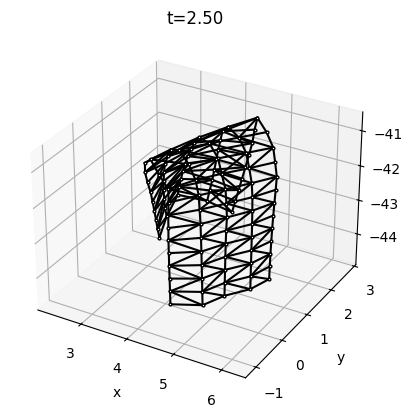

Current time =2.505000
Iter =  1  error= 173891.05498672728
Iter =  2  error= 100426.87753057416
Iter =  3  error= 474.1063877207099
Iter =  4  error= 11.478005087248093
Iter =  5  error= 0.4783515299734965
Current time =2.510000
Iter =  1  error= 173886.4918507836
Iter =  2  error= 99134.5589275753
Iter =  3  error= 473.07519544562626
Iter =  4  error= 11.50725820354506
Iter =  5  error= 0.4786425085865246
Current time =2.515000
Iter =  1  error= 173879.4869038678
Iter =  2  error= 97885.30988906657
Iter =  3  error= 472.30615345870183
Iter =  4  error= 11.548692408963332
Iter =  5  error= 0.47891783204633787
Current time =2.520000
Iter =  1  error= 173868.41942446487
Iter =  2  error= 96530.75748037544
Iter =  3  error= 471.6507511987455
Iter =  4  error= 11.596752945300388
Iter =  5  error= 0.4791778768440164
Current time =2.525000
Iter =  1  error= 173853.01187414397
Iter =  2  error= 95136.57304894735
Iter =  3  error= 471.17093562872174
Iter =  4  error= 11.645166740459473
Iter =

KeyboardInterrupt: 

In [ ]:
Nsteps = round(totalTime / dt) # Number of time steps
ctime = 0 # Current time
endZ = np.zeros(Nsteps) # z-coordinate of the last node

for timeStep in range(Nsteps):
  print('Current time =%f' % ctime)

  qNew, uNew = objfun(qOld, uOld, freeIndex, dt, tol, massVector, massMatrix,
                      ks, refLen, edges, kb, thetaBar, hinges, Fg, visc,
                      rho_fluid, Cd_n, Cd_t, u_f)

  ctime += dt

  # Update my old positions and velocities
  qOld = qNew.copy()
  uOld = uNew.copy()

  # Store endZ
  endZ[timeStep] = qNew[-1]

  # Plot the shell
  if timeStep % 100 == 0:
    plotShell(qOld, ctime)

In [ ]:
# Visualize
plt.figure(2)
time_array = np.arange(1, Nsteps+1) * dt
plt.plot(time_array, endZ, 'ro-')
plt.box(True)
plt.xlabel('Time, t [sec]')
plt.ylabel('z-coord of last node, $\\delta_z$ [m]')
plt.show()

In [ ]:
endZ[-1]

## Video Generating code

In [ ]:
# Figure and writer for the movie
fig_movie = plt.figure(figsize=(6, 6))
ax_movie = fig_movie.add_subplot(111, projection='3d')

metadata = dict(title='Shell simulation', artist='Matplotlib')
writer = FFMpegWriter(fps=30, metadata=metadata)

Nsteps = round(totalTime / dt) # Number of time steps
ctime = 0 # Current time
endZ = np.zeros(Nsteps) # z-coordinate of the last node

endZ_0 = qOld[-1] # End Z coordinate of the last node
endZ = np.zeros(Nsteps)

midX_0 = qOld[(midNode+2)*5] # X coordinate of the mid node
midX = np.zeros(Nsteps)

midY_0 = qOld[(midNode+2)*5+1] # Y coordinate of the mid node
midY = np.zeros(Nsteps)

midZ_0 = qOld[(midNode+2)*5+2] # Z coordinate of the mid node
midZ = np.zeros(Nsteps)

height = np.zeros(Nsteps)

with writer.saving(fig_movie, "rod_movie.mp4", dpi=150):

  for timeStep in range(Nsteps):
    print('Current time =%f' % ctime)

    qNew, uNew = objfun(qOld, uOld, freeIndex, dt, tol, massVector, massMatrix,
                        ks, refLen, edges, kb, thetaBar, hinges, Fg, visc,
                        rho_fluid, Cd_n, Cd_t, u_f)

    # Save Z-Coord of relevant nodes
    endZ[timeStep]   = qNew[-1] - endZ_0
    midZ[timeStep]   = qNew[(midNode+2)*5+2] - midZ_0 # Z coordinate of the mid node
    height[timeStep] = midZ[timeStep] - endZ[timeStep]
    midX[timeStep] = qNew[(midNode+2)*5+ 0] # X coordinate of the mid node
    midY[timeStep] = qNew[(midNode+2)*5 + 1] # Y coordinate of the mid node

    # --- Draw rod and grab frame for the movie ---
    plotShell_movie(qOld, ctime, ax=ax_movie, show=False)
    writer.grab_frame()

    ctime += dt

    # Update my old positions and velocities
    qOld = qNew.copy()
    uOld = uNew.copy()


Video("rod_movie.mp4", embed=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.figure()
time_array = np.arange(1, Nsteps+1, 1) * dt
plt.plot(time_array, endZ, 'ro-')
plt.xlabel('Time (s)')
plt.ylabel('End Z (m)')
plt.show()

terminal_velocity = np.gradient(endZ, dt)
plt.figure()
time_array = np.arange(1, Nsteps+1, 1) * dt
plt.plot(time_array, terminal_velocity, 'ro-')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.show()

plt.figure()
time_array = np.arange(1, Nsteps+1, 1) * dt
plt.plot(time_array, height, 'ro-')
plt.xlabel('Time (s)')
plt.ylabel('Relative Hightest Point (m)')
plt.show()

terminal_velocity[-1]

NameError: name 'plt' is not defined